# ZIEL:

* Data-Cube mit folgenden Dimensionen für jeden Sensor
    * Zeitachse (inkl. zeitl. Verschiebung über die Radar Daten)
    * x-Dimension (Ost-West)
    * y-Dimension (Nord-Süd)

* Für jeden Sensor ein Sensor-Objekt
    * Im Sensor-Objekt die Zeitreihen für die gewählten Weiten in jede Richtung festlegen
    * Korellationen zwischen den Zeitreihen ebenso als Cube
    * Timeseries für die Radar-Fläche als List of lists. an Stelle[i, j] steht jeweils ein Dataframe mit der jeweiligen Gridposition (siehe Skizze)
        *   [[-1;-1, 0;-1, 1;-1]
             [-1;0, 0;0, 1;0]
             [-1;1, 0;1, 1;1]]
    * Auswertung als Korellation bzw. Werteabgleich
    
* Zukunfstmusik: Fractions Skill Score (FSS)
    * https://www.authorea.com/users/650600/articles/659203-the-fractions-skill-score-for-ensemble-forecast-verification





# Ziel (Thomas):

## Daten
* Datacube mit Sensor & Radardaten je Regenereignis.
    * dabei die Radardaten als 3d-array (lon, lat, time)
    * Die Sensordaten korrespondierend mit jeweiliger Timeseries, sowie information über lon und lat
    * alternative Ortungsdaten auch Gridposition

## Auswertung
* Auswertung der Korrelation der Timeseries in jede Dimension der Radar-Daten
    * Als Korrellationswert in Form eines Ergebniswürfels in Dimensionen:
        * Timeshift: bspw [-5, 0, 5]
        * lat-shift: bspw [-1, 0, 1]
        * lon-shift: bspw [-1, 0, 1]
* Detaillierte Auswertung des "optimalen" Ergebnis
    * --> "optimales" Ergebnis ist die Verschiebung, die im Mittel die beste Korellation hat. Auswertung über Durchschnittswerte der einzelnen Ergebniswürfel
    * als Ergebniswürfel
        * Im Ergebniswürfel Farbliche Darstellung, je nach korellation
        * Mittelwerte der Korrelationen über das ganze Event.
        * --> hier wird das optimale Ergebnis sichtbar.
    * Sensordaten dabei "statisch" und unverändert 
        * Sensoren mit Niederschlagswert unter <X> für das Regenereignis müssen nicht ausgewertet werden
            * <X> hierbei veränderlich und am Anfang einstellbar.

## Ausgabe
* Export der Zeitreihen je Sensor und je zugehöriges Radarpixel, so dass sie visualisiert werden können (z.B. in TimeView)
    * Zeitreihen je Sensor 
        * Auswahl:
            * jede Durchgeführte Verschiebung
            * nur unverschoben, Eventoptimum und individualoptimum
    * Format: --> UVF


## Zusätzlich:
* Erkennung interessanter Ereignisse:
    * bspw. Scraper über Sensordaten --> mind. <A> Sensoren erreichen in Zeiteinheit <B> eine Klasse von <C>
    * --> Entkoppelt von der Auswertung.


In [164]:

from datetime import datetime as dt, timedelta as td
import os
import numpy as np
import pandas as pd
from helpers.sensor_helpers import * 
from helpers.radar_helpers import *
import netCDF4
import xarray as xr
import geopandas as gpd

SENSOR_DATA_PATH = r"DATA\\last6months_140824"


In [165]:
class SensorEventClass:
    """WIP"""

    #ZIEL: DEN GANZEN SPAß FÜR EINEN SENSOR HINBEKOMMEN.
    # --> Funktioniert es für einen, funktioniert es für alle
    
    # definitions
    date_format = "%Y-%m-%d %H:%M:%S"
    
    
    def __init__(self, 
                 eid: str,
                 sensor_id: int,
                 lat: float,
                 lon: float,
                 start: dt,
                 end: dt,
                 folderpath: str,
                 row: int,
                 col: int,
                 test=False,
                 **kwargs):
        
        """
        Erstellen eines Sensor-Objekts.
        Sämtliche gegebene Variablen werden im Sensor gespeichert.
        Der Sensor erhält zusätzlich die korrespondierende Timeseries für das Event als DataFrame-Objekt
        
        Args:
            eid (_str_): EID dess Sensors (bspw E70ED)
            sensor_id (_int_): Sensor-id zur identifikation (bspw 13361)
            lat (_float_): karthesische (?) Latitude (Breite)
            lon (_float_): krathesische (?) Longitude (Länge)
            start (datetime.Datetime): Datetime-Objekt des Event-Startzeitpunktes
            end (datetime.Datetime): Datetime-Objekt des Event-Endzeitpunktes
            folderpath (_str_): Ablageort der Rohdaten für die Sensoren
            row (_int_): Reihennummer (row) im Pixelgrid (zur Identifikation im xarray)
            col (_int_): Spaltennummer (column) im Pixelgrid (zur Identifikation im xarray)
            test (_bool_): Aktivierung / deaktivierung der Testumgebung
        """
        # Grundelegende Variablen in Objekt speichern
        self.eid = eid
        self.sensor_id = sensor_id
        self.lat = lat
        self.lon = lon
        self.row = row
        self.col = col
        self.name = eid
        
        # Event Timeframe aus der init erhalten
        self.set_event_timeframe(start, end)
        
        # Dataframe für die Station über die Helper-Funktion generieren. 
        self.station_df = create_single_sensor_df(self.sensor_id, folderpath,
                                                    self.__start_datetime, self.__end_datetime)

        
    
    def __str__(self):
        """
        Ausgabe aller relevanten Variablen als String

        Returns:
            str: 
        """
        print(f'(eid = {self.eid}) (sensor_id = {self.sensor_id})')
        print(f'(lat = {self.lat}) (lon = {self.lon})')
        print(f"(row = {self.row}) (col = {self.col})")
        return f'(start = {self.__start_timestring}) (end = {self.__end_timestring})'
        
         

    def print_event_timeframe(self):
        """
        Ausgabe des Event-Timeframes dieses Sensorobjekts als String
        """
        
        print(f"Timeframe: {self.__start_timestring} - {self.__end_timestring}")
        
        
            
    def set_event_timeframe(self, start: dt, end: dt):
        """
        generiert Datetime, sowie String Klassenobjekte für Start- und Endzeitpunkt des Events
        erstellt zusätzlich eine date_range 
        
        OHNE PUFFER(!!!!!)

        Args:
            start (datetime.Datetime): datetime-Objekt zum Startzeitpunkt (minutengenau)
            end (datetime.Datetime): datetime-Objekt zum Endzeitpunkt (minutengenau)
        """
        
        
        # Datetimes im Objekt speichern
        self.__start_datetime = dt.strptime(start, self.date_format)
        self.__end_datetime = dt.strptime(end, self.date_format)
        
        # Strings im Objekt speichern
        self.__start_timestring = start
        self.__end_timestring = end
        
        # date_range im Objekt aus Start- und Endzeit generieren und im Objekt speichern
        self.__timerange = pd.date_range(self.__start_datetime, self.__end_datetime, freq="5min")
    
    
    def input_timeframe(self):
        """
        NUR NOTIG FALLS UNABHÄNGIGES <SensorEventClass>-Objekt erstellt werden sollte
        
        setzt start- und End-Datetime im Objekt fest, indem es user nach input fragt.
        """
        
        # =========================== DEPRECATED ==============================
        
        # Solange eingaben nicht korrekt sind, wiederholt sich dieser Loop
        while True:
            print("Start- und Endzeit des Events wurden entweder nicht oder nicht korrekt angegeben.")
            print("Das Korrekte Format ist <YYYY-mm-DD HH:MM:SS>. Bspw (2024-05-10 10:00:00)")
            
            # Input-Abfrage
            start = input("Bitte geben Sie einen Startzeitpunkt an für das Regenevent an: ")
            end = input("Bitte geben Sie einen Endzeitpunkt an für das Regenevent an: ")
            
            
            try:
                self.set_event_timeframe(start, end)
                break
            except Exception as e:
                print(e)

    # getter    
    def get_station_df(self):
        return self.station_df
    
    def get_start_datetime(self): return self.__start_datetime
    def get_start_timestring(self): return self.__start_timestring
    def get_end_datetime(self): return self.__end_datetime
    def get_end_timestring(self): return self.__end_timestring
    def get_timerange(self): return self.__timerange
    
    
    def create_corr_cube(self, radar_dataset, grid_shift: int, time_shift: int):
        if not self.is_data_usable():
            self.sensor_cube = False
            return False
        
        time_range = range(-time_shift * 5, time_shift*5 +5, 5)
        lat_range = range(grid_shift*1000, -grid_shift*1000 -1000 , -1000)
        lon_range = range(-grid_shift * 1000, grid_shift * 1000 + 1000, 1000)

        corrs = []
        for ts in time_range:
            lat_corrs = []
            for lat in lat_range:
                radar_lat = self.lat + lat
                lon_corrs = []
                for lon in lon_range:
                    radar_lon = self.lon + lon
                    start = self.get_start_datetime() + td(minutes=ts)
                    end = self.get_end_datetime()+td(minutes=ts)


                    
                    shift_dr = pd.date_range(start, end, freq="5min")
                    sensor_series = pd.Series(self.get_station_df()["value"].values, index=shift_dr)
                    corresp_radar = radar_dataset.data_mapgrid.sel(lat=radar_lat,
                                                                        lon=radar_lon,
                                                                        time=shift_dr,
                                                                        method="nearest")
                    radar_series = corresp_radar.to_series()
                    curr_corr = sensor_series.corr(radar_series, method="spearman")
                    # print("lat:", radar_lat, "lon:", radar_lon)
                    # print("start:", start, "end:", end)
                    # print("correlation:", curr_corr, "\n")
                    lon_corrs.append(curr_corr)
                    
                lat_corrs.append(lon_corrs)
            
            corrs.append(lat_corrs)
            
        self.sensor_cube = xr.Dataset(
            {
                "correlations": (("time", "lat", "lon"), corrs)
            },
            coords={
                "time": time_range,
                "lat": lat_range,
                "lon": lon_range
            }
        )
    
    def is_data_usable(self):
        total_sum = self.station_df.sum()
        limit = 10
        print("\n", total_sum < limit)
        return int(total_sum) < limit
        

        

In [166]:
class EventClass:
    """
    Klasse in der sämtliche Daten eines Events gespeichert, 
    zusammengefeasst, ausgewertet und expertortiert werden sollen.
    """
    
    # Generelle Deklaration Objekt-Spezifischer Variablen
    #   --> Könnte auch in einer Config-File genutzt werden im produktiv-build
    date_format = "%Y-%m-%d %H:%M:%S"
    radar_filepath = r"Data\\radar_data"
    sensor_folderpath = r"Data\\last6months_140824"
    sensor_info_fp = r"Data\\sensor_information.csv"
    map_grid_file = r"Data\\grid_geojson_4326_small.geojson"
    
    def __init__(self, start="2024-05-26 12:00:00", end="2024-05-26 14:20:00", 
                 time_shift=1, grid_shift=1, test=False, **kwargs):
        
        # Schreiben der Input-Daten in das Objekt
        self.time_shift = time_shift
        self.start_timestring = start
        self.end_timestring = end
        self.grid_shift = grid_shift
        
        # festlegen Schreiben der lat- und lon-Werte in das Objekt über Helper-Funktion
        self.lat_values, self.lon_values = get_grid_coords(self.map_grid_file)
        
        # Sofern input des Timeframes inkorrekt --> Loop, bis korrekt
        while True:
            try: 
                self.set_event_timeframe(start, end)
                break
            except Exception as e:
                print(e)
                print("bitte geben Start- und Endzeitpunkt erneut angeben. Format: <YYYY-mm-DD HH:MM:SS>")
                start = input("Startzeitpunkt <YYYY-mm-DD HH:MM:SS>: ")
                end = input("Endzeitpunkt <YYYY-mm-DD HH:MM:SS>: ")
        
        
        if not test:
            # Radar Files in <Data/radar_data> laden
            get_radar_files(self.__start_datetime.strftime(self.date_format),
                            self.__end_datetime.strftime(self.date_format),
                            self.radar_filepath)
        
        #TODO TEST THIS !!!!!
        # neu festlegen von vorher festgeschriebenen Variablen, falls anders angegeben
        if "sensor_folderpath" in kwargs.keys():
            self.sensor_folderpath = kwargs["sensor_folderpath"]
            
        if "radar_filepath" in kwargs.keys():
            self.radar_filepath = kwargs["radar_filepath"]
            
        # Sensor-Daten in das Objekt einladen
        self.load_sensor_data()
        
        # Daten-Cube für die Radar-Daten in das Objekt einladen
        self.create_radar_data_cube()
            
            
            
    def create_radar_data_cube(self):
        """
        
        Schreibt Radar-Daten innerhalb des Event-Zeitraums in zwei verschiedene Datenobjekte:
            radar_df (pandas.DataFrame): Dataframe-Objekt mit Timestamp als Spaltenindex und der pixelID des array-Grids als Zeilenindex
            
            radar_dataset (xarray.Dataset): Dataset-Objekt mit 5 Dimensionen (time, lat, lon, row, col)
                                            und zwei (inhaltlich identischen) Datensätzen:
                                                data_mapgrid (lat, lon, time): Daten mit zugehörigen karthesischen Koordinaten
                                                data_pxgrid  (row, col, time): Daten mit zugehörigen Pixelkoordinaten

        Raises:
            e: error
        """
        
        # generieren einer Dateiliste (funktioniert nur mit Dateien von bo-it)
        files_list = [f"hd{timeframe.strftime('%y%m%d%H%M')}.scu" for timeframe in self.__timerange]
        
        # vordefinition von Variablen
        radar_data_dict = {}
        self.array_3d = []
        
        # Extraktionsschleife zur extraktion der Daten aus den rohen .scu-Files --> Bruno Castro
        for file in files_list: 
            """Author: Bruno Castro"""
            filestring = os.path.join(self.radar_filepath, file)
            timestamp = dt.strptime(file, "hd%y%m%d%H%M.scu")
            try:
                ncf = netCDF4.Dataset(filestring, mode="r")
                image_data = ncf.groups["dataset_DXk"].variables["image"][:]
                ncf.close()
            except Exception as e:
                print(e)
                raise e

            # Extract and process the specific array sections
            array_result = [image_data[i, 147:201] for i in range(119, 153)]
            #transposed_arrays = list(map(list, zip(*array_result)))
            #array_result = np.array(transposed_arrays)/12  ##Divide per 12 to give the result in mm
            self.array_3d.append(array_result)
            # Flatten the nested list
            list_array = [item for sublist in array_result for item in sublist]
            # get pixeldata and append to corresponding gridposition
            try:
                radar_data_dict["time"].append(timestamp)
                for pixel_id, value in enumerate(list_array):
                    radar_data_dict[pixel_id].append(value)
            except KeyError as e:
                radar_data_dict["time"] = [timestamp]
                for pixel_id, value in enumerate(list_array):
                    radar_data_dict[pixel_id] = [value]
                    
        
        # Einladen der 3darray-Liste in ein xarray-Dataset
        self.radar_dataset = xr.Dataset(
            {
                "data_mapgrid": (("time", "lat", "lon"), self.array_3d),
                "data_pxgrid": (("time", "row", "col"), self.array_3d)
            },
            coords={
                "time": self.__timerange,
                "lat": self.lat_values[::-1],  # UL-Ursprung --> beginnt beim größten (letzten) lat-Wert
                "lon": self.lon_values,
                "row": range(1, len(self.lat_values) + 1),
                "col": range(1, len(self.lon_values) + 1)
            }
        )    
        
        # create pd.Dataframe object from dict 
        self.radar_df = pd.DataFrame(radar_data_dict)
        
        # Zeit als Index setzen
        self.radar_df = self.radar_df.set_index("time")
        
            
    
        
    def print_event_timeframe(self):
        """ Druck des gegebene Zeitfensters, sowie des Zetifensters mit dem gerechnet wird (inkl buffer)
        """
        print(f"gegebener Timeframe: {self.__start_timestring} - {self.__end_timestring}")
        print(f"Timeframe Rechnung: {self.__start_datetime} - {self.__end_datetime}")
    
    # Getters für Zeitdaten
    def get_start_datetime(self): return self.__start_datetime
    def get_end_datetime(self): return self.__end_datetime
    def get_start_timestring(self): return self.__start_timestring
    def get_end_timestring(self): return self.__end_timestring
    
    
    def set_event_timeframe(self, start, end):
        """
        generiert Datetime, sowie String Klassenobjekte für Start- und Endzeitpunkt des Events.
        Die Datetime-Objekte sind mit dem time-Buffer verschoben
        
        Außerdem erstellt eine date_range mit 5Minuten-timespaces zwischen Anfang und Ende des Events erstellt
        5-Minuten Fenster deshalb, da die Radar-Daten nicht in kürzeren Abständen gemessen werden.

        Args:
            start (_str_): Startzeitpunkt des Events
            end (_str_): Endzeitpunkt des Events
        """
        self.__start_datetime = dt.strptime(start, self.date_format) - td(minutes=5*self.time_shift)
        self.__end_datetime = dt.strptime(end, self.date_format) + td(minutes=5*self.time_shift)
        self.__timerange = pd.date_range(self.__start_datetime, self.__end_datetime, freq="5min")
        self.__start_timestring = start
        self.__end_timestring = end  
    
    
    def input_timeframe(self):
        """Generierung des Timeframes über Nutzerinputs
        """
        
        while True:
            print("Start- und Endzeit des Events wurden entweder nicht oder nicht korrekt angegeben.")
            print("Das Korrekte Format ist <YYYY-mm-DD HH:MM:SS>. Bspw (2024-05-10 10:00:00)")
            
            start = input("Bitte geben Sie einen Startzeitpunkt an für das Regenevent an: ")
            end = input("Bitte geben Sie einen Endzeitpunkt an für das Regenevent an: ")
            
            try:
                self.set_event_timeframe(start, end)
                break
            except Exception as e:
                print(e)


    def load_sensor_data(self, filter=-1):
        """_summary_
        ZIEL:
        - Für jeden Sensor ein Individuelles Objekt mit infos zu:
            - lat, lon, EID, sensor-ID, timeseries
        - ein Dataframe <sensor-id - timeseries> mit allen Sensoren
        - ein Dataframe mit < sensor-ID - lat|lon> mit allen Sensoren
        - Jedes Sensorobjekt soll dann mit den korresp. verschobenen Timeseries ausgestattet werden können
        

        Args:
            filter (int, optional): _description_. Defaults to -1.
        """
        
        # einlesen des Informations-DF mit sämtliche für die einzelnen Sensoren
        info_cols = ["dev_eui", "Latitude", "Longitude", "Stationsnr", "row", "col" ]
        self.sensor_info_df = pd.read_csv(self.sensor_info_fp, sep=";", 
                                          usecols= info_cols)
        
        # Namensanpassung
        self.sensor_info_df = self.sensor_info_df.rename(columns={"dev_eui": "EID",
                                                                  "Latitude": "lat",
                                                                  "Longitude": "lon",
                                                                  "Stationsnr": "sensor_id"})
        
        # Erstellung aller Sensoren. Einmal abgelegt in einem dict und einer Liste
        self.sensors_list = []
        self.Sensors = {}
        for index, row in self.sensor_info_df.iterrows():
            #print(row)
            sensor = SensorEventClass(eid = row["EID"], sensor_id = row["sensor_id"],
                                      lat = row["lat"], lon=row["lon"],
                                      row = row["row"], col = row["col"],
                                      start=self.get_start_timestring(),
                                      end=self.get_end_timestring(),
                                      folderpath=self.sensor_folderpath)
            self.Sensors[sensor.name] = sensor
            self.sensors_list.append(sensor)
            
        
        # Erstellung eines Dataframes mit allen timeseries jedes Sensors
        self.sensor_timeseries_df = pd.DataFrame({sensor.name: sensor.get_station_df().value for sensor in self.sensors_list})

    def create_corr_cubes(self, sensor_list="default"):
        if sensor_list == "default":
            sensor_list = self.sensors_list
        for sensor in sensor_list:
            print(f"creating cube for sensor {sensor.name}", end="...")
            sensor.create_corr_cube(radar_dataset=self.radar_dataset, 
                                    grid_shift=self.grid_shift, 
                                    time_shift=self.time_shift)
            print("done")
            
        print("Cubes created for each sensor from the list.")
        

        
    
    def produce_graphical_output():
        #TODO
        pass
    
    def produce_uvf(switch="basic"):
        # Switch: --> datailed/basic
        #TODO 
        pass

In [167]:

TestIng = EventClass(start="2024-05-26 12:00:00", end="2024-05-26 14:20:00", test=True)

In [168]:
TestIng.create_corr_cubes()

creating cube for sensor E570D...
 value    True
dtype: bool
done
creating cube for sensor E7DE6...
 value    False
dtype: bool
done
creating cube for sensor E5BA7...
 value    False
dtype: bool
done
creating cube for sensor E436B...
 value    True
dtype: bool
done
creating cube for sensor E5B98...
 value    True
dtype: bool


C:\Users\thomas\AppData\Local\Temp\ipykernel_17800\4270357312.py:197: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(total_sum) < limit
c:\Python310\lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


done
creating cube for sensor E4E8B...
 value    False
dtype: bool
done
creating cube for sensor E6040...
 value    True
dtype: bool
done
creating cube for sensor E53B4...
 value    True
dtype: bool
done
creating cube for sensor E57D3...
 value    False
dtype: bool
done
creating cube for sensor E5268...
 value    False
dtype: bool
done
creating cube for sensor E3C10...
 value    True
dtype: bool
done
creating cube for sensor E7A34...
 value    False
dtype: bool
done
creating cube for sensor E434E...
 value    False
dtype: bool
done
creating cube for sensor E7052...
 value    True
dtype: bool
done
creating cube for sensor E73A3...
 value    False
dtype: bool
done
creating cube for sensor E5217...
 value    False
dtype: bool
done
creating cube for sensor E4AC1...
 value    False
dtype: bool
done
creating cube for sensor E761F...
 value    False
dtype: bool
done
creating cube for sensor E572D...
 value    True
dtype: bool
done
creating cube for sensor E5B9D...
 value    False
dtype: bool


In [169]:
test_sensor = TestIng.sensors_list[5]
print(test_sensor)

(eid = E4E8B) (sensor_id = 13366)
(lat = 5967980.8) (lon = 610177.47)
(row = 26) (col = 23)
(start = 2024-05-26 12:00:00) (end = 2024-05-26 14:20:00)


In [170]:
test_sensor.sensor_cube

False

In [171]:
%matplotlib inline
test_sensor.sensor_cube.plot.scatter(x="lat", y="time", z="lon", hue="correlations", s=10)


AttributeError: 'bool' object has no attribute 'plot'

In [ ]:
ts1 = TestIng.sensors_list[2]
ts2 = TestIng.sensors_list[5]
tsNan = TestIng.sensors_list[3]

In [172]:
active_sensor_cubes = [sensor for sensor in TestIng.sensors_list if sensor.is_data_usable()]



 value    True
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    True
dtype: bool

 value    True
dtype: bool

 value    False
dtype: bool

 value    True
dtype: bool

 value    True
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    True
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    True
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    True
dtype: bool

 value    False
dtype: bool

 value    True
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    True
dtype: bool

 value    True
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    False
dtype: bool

 value    False
dtype: b

C:\Users\thomas\AppData\Local\Temp\ipykernel_17800\4270357312.py:197: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(total_sum) < limit


In [173]:
active_sensor_cubes[0].station_df.sum()

value    9.0
dtype: float64

In [174]:
for sensor in active_sensor_cubes:
    print(sensor.sensor_cube.to_array())

<xarray.DataArray (variable: 1, time: 3, lat: 3, lon: 3)> Size: 216B
array([[[[-0.5, -0.5,  0.5],
         [-0.5,  0.5,  nan],
         [-0.5,  0.5,  1. ]],

        [[ 0.5,  1. ,  0.5],
         [ 1. ,  0.5,  nan],
         [ 1. ,  0.5,  0.5]],

        [[ 0.5,  0.5,  0.5],
         [ 0.5,  0.5,  nan],
         [-0.5, -0.5,  0.5]]]])
Coordinates:
  * time      (time) int64 24B -5 0 5
  * lat       (lat) int64 24B 1000 0 -1000
  * lon       (lon) int64 24B -1000 0 1000
  * variable  (variable) object 8B 'correlations'
<xarray.DataArray (variable: 1, time: 3, lat: 3, lon: 3)> Size: 216B
array([[[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]]])
Coordinates:
  * time      (time) int64 24B -5 0 5
  * lat       (lat) int64 24B 1000 0 -1000
  * lon       (lon) int64 24B -1000 0 1000
  * variable  (variable) obje

In [ ]:
int(ts1.station_df.isna().sum())

C:\Users\thomas\AppData\Local\Temp\ipykernel_17800\3143783745.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(ts1.station_df.isna().sum())


14

In [ ]:
len(ts1.station_df)

29

In [ ]:
avg = sum(ts1.sensor_cube, ts2.sensor_cube) /2
avg.mean()

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U12')) -> None

In [ ]:
currsen = TestIng.Sensors["E46BE"]
currsen.create_corr_cube(radar_dataset=TestIng.radar_dataset,
                         grid_shift=3, time_shift=TestIng.time_shift)

In [ ]:
currsen.sensor_cube

<xarray.Dataset> Size: 1kB
Dimensions:       (time: 3, lat: 7, lon: 7)
Coordinates:
  * time          (time) int64 24B -5 0 5
  * lat           (lat) int64 56B 3000 2000 1000 0 -1000 -2000 -3000
  * lon           (lon) int64 56B -3000 -2000 -1000 0 1000 2000 3000
Data variables:
    correlations  (time, lat, lon) float64 1kB 0.4525 0.4126 ... 0.03104 0.01426

In [ ]:

time_shift = 1
grid_shift = 1
time_range = range(-time_shift * 5, time_shift*5 +5, 5)
lat_range = range(grid_shift*1000, -grid_shift*1000 -1000 , -1000)
lon_range = range(-grid_shift * 1000, grid_shift * 1000 + 1000, 1000)

corrs = []
for ts in time_range:
    lat_corrs = []
    for lat in lat_range:
        radar_lat = currsen.lat + lat
        lon_corrs = []
        for lon in lon_range:
            radar_lon = currsen.lon + lon
            start = currsen.get_start_datetime() + td(minutes=ts)
            end = currsen.get_end_datetime()+td(minutes=ts)


            
            shift_dr = pd.date_range(start, end, freq="5min")
            sensor_series = pd.Series(currsen.get_station_df()["value"].values, index=shift_dr)
            corresp_radar = TestIng.radar_dataset.data_mapgrid.sel(lat=radar_lat,
                                                                lon=radar_lon,
                                                                time=shift_dr,
                                                                method="nearest")
            radar_series = corresp_radar.to_series()
            curr_corr = sensor_series.corr(radar_series, method="spearman")
            # print("lat:", radar_lat, "lon:", radar_lon)
            # print("start:", start, "end:", end)
            # print("correlation:", curr_corr, "\n")
            lon_corrs.append(curr_corr)
            
        lat_corrs.append(lon_corrs)
    
    corrs.append(lat_corrs)
    
    
corrs
sensor_cube = xr.Dataset(
    {
        "correlations": (("time", "lat", "lon"), corrs)
    },
    coords={
        "time": time_range,
        "lat": lat_range,
        "lon": lon_range
    }
)


In [ ]:
corrs

[[[np.float64(0.642139775729338),
   np.float64(0.25325314587345177),
   np.float64(0.21499509120405746)],
  [np.float64(0.7849432297545027),
   np.float64(0.5337809160928323),
   np.float64(0.22134962591944832)],
  [np.float64(0.8161362617585269),
   np.float64(0.712121647836357),
   np.float64(0.3018403989810659)]],
 [[np.float64(0.7537914766193411),
   np.float64(0.42703354722594594),
   np.float64(0.16441378461074044)],
  [np.float64(0.6445924300767362),
   np.float64(0.5051855098735735),
   np.float64(0.29563860961796246)],
  [np.float64(0.5475490746428459),
   np.float64(0.4956196863481054),
   np.float64(0.22782186762674528)]],
 [[np.float64(0.38888662985588623),
   np.float64(0.28943048258379767),
   np.float64(0.2160015756761507)],
  [np.float64(0.24078663939766504),
   np.float64(0.1578042787655397),
   np.float64(0.2876079978593931)],
  [np.float64(0.1174982166734066),
   np.float64(0.07853502524573833),
   np.float64(0.20472168019272843)]]]

In [ ]:
sensor_cube

<xarray.Dataset> Size: 288B
Dimensions:       (time: 3, lat: 3, lon: 3)
Coordinates:
  * time          (time) int64 24B -5 0 5
  * lat           (lat) int64 24B 1000 0 -1000
  * lon           (lon) int64 24B -1000 0 1000
Data variables:
    correlations  (time, lat, lon) float64 216B 0.6421 0.2533 ... 0.07854 0.2047

In [ ]:
new_dr = pd.date_range(start= currsen.get_start_datetime() - td(minutes=5),
                          end=currsen.get_end_datetime() - td(minutes=5),
                          freq="5min")

In [ ]:
sensor_series

2024-05-26 12:05:00    NaN
2024-05-26 12:10:00    NaN
2024-05-26 12:15:00    NaN
2024-05-26 12:20:00    NaN
2024-05-26 12:25:00    NaN
2024-05-26 12:30:00    NaN
2024-05-26 12:35:00    NaN
2024-05-26 12:40:00    3.0
2024-05-26 12:45:00    3.0
2024-05-26 12:50:00    NaN
2024-05-26 12:55:00    3.0
2024-05-26 13:00:00    0.0
2024-05-26 13:05:00    NaN
2024-05-26 13:10:00    2.0
2024-05-26 13:15:00    3.0
2024-05-26 13:20:00    6.0
2024-05-26 13:25:00    6.0
2024-05-26 13:30:00    7.0
2024-05-26 13:35:00    7.0
2024-05-26 13:40:00    7.0
2024-05-26 13:45:00    6.0
2024-05-26 13:50:00    2.0
2024-05-26 13:55:00    3.0
2024-05-26 14:00:00    6.0
2024-05-26 14:05:00    6.0
2024-05-26 14:10:00    5.0
2024-05-26 14:15:00    2.0
2024-05-26 14:20:00    NaN
2024-05-26 14:25:00    NaN
Freq: 5min, dtype: float64

In [ ]:
new_sensor_series = pd.Series(sensor_series.values, index=new_dr)
new_sensor_series

2024-05-26 11:55:00    NaN
2024-05-26 12:00:00    NaN
2024-05-26 12:05:00    NaN
2024-05-26 12:10:00    NaN
2024-05-26 12:15:00    NaN
2024-05-26 12:20:00    NaN
2024-05-26 12:25:00    NaN
2024-05-26 12:30:00    3.0
2024-05-26 12:35:00    3.0
2024-05-26 12:40:00    NaN
2024-05-26 12:45:00    3.0
2024-05-26 12:50:00    0.0
2024-05-26 12:55:00    NaN
2024-05-26 13:00:00    2.0
2024-05-26 13:05:00    3.0
2024-05-26 13:10:00    6.0
2024-05-26 13:15:00    6.0
2024-05-26 13:20:00    7.0
2024-05-26 13:25:00    7.0
2024-05-26 13:30:00    7.0
2024-05-26 13:35:00    6.0
2024-05-26 13:40:00    2.0
2024-05-26 13:45:00    3.0
2024-05-26 13:50:00    6.0
2024-05-26 13:55:00    6.0
2024-05-26 14:00:00    5.0
2024-05-26 14:05:00    2.0
2024-05-26 14:10:00    NaN
2024-05-26 14:15:00    NaN
Freq: 5min, dtype: float64

In [ ]:
radar_series.corr(sensor_series)

np.float64(0.004404104019791658)

In [ ]:
currsen_series = currsen.get_station_df()["value"]
print(len(currsen_series), len(corresp_radar))


29 29


# TESTING GROUNDS

In [ ]:
newclass.create_radar_data_cube()

NameError: name 'newclass' is not defined

In [ ]:
with open("Data\\epsg25832_sensor_loc.csv", "r") as file:
    lines = file.readlines()
    outfile = "test.csv"
    with open(outfile, "w") as outfile:
        firstline = True
        for line in lines:
            if firstline:
                outfile.write(line)
                firstline = False
                continue
        
            line = line[1:-2]
            line = line + "\n"
            print(line)
            outfile.write(line)
        

                

13361,5961048.71362561,610352.843871651,E570D,""3""

13362,5967276.05489108,609018.946355368,E7DE6,""41""

13363,5968958.89811689,606855.02598569,E5BA7,""39""

13364,5968052.19780357,614803.420347635,E436B,""133""

13365,5970170.68204702,614663.045614793,E5B98,""22""

13366,5967980.80120424,610177.473069398,E4E8B,""55""

13367,5970049.77246009,613004.960251143,E6040,""2""

13368,5981825.02729039,622305.19033566,E53B4,""6""

13369,5971741.89613675,610898.849543834,E57D3,""26""

13370,5968326.23496352,611351.938827188,E5268,""20""

13371,5966317.02280626,609301.795705995,E3C10,""9""

13372,5968078.1210549,608056.194400233,E7A34,""1""

13374,5971321.48352334,609755.736299659,E434E,""36""

13375,5967291.2705118,610497.864147632,E7052,""78""

13376,5970513.80078671,610352.493844941,E73A3,""1""

13377,5970790.37301928,610905.044635543,E5217,""311""

13379,5966311.84328823,605859.78241154,E4AC1,""7""

13380,5968479.04806477,610207.629035565,E761F,""10""

13381,5973807.15926964,619545.66336385

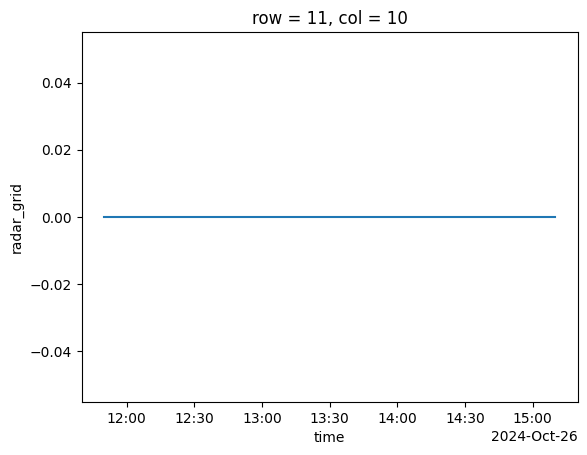

In [ ]:
newclass.radar_dataset.sel(row=11, col=10).radar_grid.plot()

In [ ]:
TestIng.radar_dataset.to_netcdf("test.nc")

In [ ]:
TestIng.radar_dataset.sel(time="2024-05-26 12:00:00")

<xarray.Dataset> Size: 16kB
Dimensions:     (lat: 34, lon: 54, row: 34, col: 54)
Coordinates:
    time        datetime64[ns] 8B 2024-05-26T12:00:00
  * lat         (lat) int64 272B 5960019 5961019 5962019 ... 5992019 5993019
  * lon         (lon) int64 432B 588123 589123 590123 ... 639123 640123 641123
  * row         (row) int64 272B 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34
  * col         (col) int64 432B 1 2 3 4 5 6 7 8 9 ... 47 48 49 50 51 52 53 54
Data variables:
    radar_loc   (lat, lon) float32 7kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.2
    radar_grid  (row, col) float32 7kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.2

In [ ]:
ncf = netCDF4.Dataset(r"E:\Python Philipp\Heavy Rain\2_create_data_cubes\Data\radar_data\hd2405261225.scu", "r")

In [ ]:
ncf.close()

In [ ]:
import h5py as h5

In [ ]:
with h5.File(r"E:\Python Philipp\Heavy Rain\2_create_data_cubes\Data\radar_data\hd2405261225.scu", "r") as f:
    print(f.keys())
    print(f["where"].items())


<KeysViewHDF5 ['dataset_DXk', 'how', 'what', 'where']>
ItemsViewHDF5(<HDF5 group "/where" (0 members)>)


In [ ]:
TestIng.radar_dataset

<xarray.Dataset> Size: 258kB
Dimensions:  (time: 35, lat: 34, lon: 54)
Coordinates:
  * time     (time) datetime64[ns] 280B 2024-05-26T11:45:00 ... 2024-05-26T14...
  * lat      (lat) int64 272B 5960019 5961019 5962019 ... 5992019 5993019
  * lon      (lon) int64 432B 588123 589123 590123 ... 639123 640123 641123
Data variables:
    radar    (time, lat, lon) float32 257kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [ ]:
TestIng.radar_df.index

DatetimeIndex(['2024-05-26 11:45:00', '2024-05-26 11:50:00',
               '2024-05-26 11:55:00', '2024-05-26 12:00:00',
               '2024-05-26 12:05:00', '2024-05-26 12:10:00',
               '2024-05-26 12:15:00', '2024-05-26 12:20:00',
               '2024-05-26 12:25:00', '2024-05-26 12:30:00',
               '2024-05-26 12:35:00', '2024-05-26 12:40:00',
               '2024-05-26 12:45:00', '2024-05-26 12:50:00',
               '2024-05-26 12:55:00', '2024-05-26 13:00:00',
               '2024-05-26 13:05:00', '2024-05-26 13:10:00',
               '2024-05-26 13:15:00', '2024-05-26 13:20:00',
               '2024-05-26 13:25:00', '2024-05-26 13:30:00',
               '2024-05-26 13:35:00', '2024-05-26 13:40:00',
               '2024-05-26 13:45:00', '2024-05-26 13:50:00',
               '2024-05-26 13:55:00', '2024-05-26 14:00:00',
               '2024-05-26 14:05:00', '2024-05-26 14:10:00',
               '2024-05-26 14:15:00', '2024-05-26 14:20:00',
               '2024-05-

In [ ]:
ds = xr.Dataset(
    data_vars={"percipitation": ["x", "y", "time"]},
    coords=dict(
        x=("x", range(500)),
        y=("y", range(500)),
        time=("time", TestIng.radar_df.index)
    ),
    dims=("x", "y", "time")
)

TypeError: Dataset.__init__() got an unexpected keyword argument 'dims'

In [ ]:
TestIng.radar_df[0]

time
2024-05-26 11:45:00    0.000000
2024-05-26 11:50:00    0.000000
2024-05-26 11:55:00    0.000000
2024-05-26 12:00:00    0.000000
2024-05-26 12:05:00    0.000000
2024-05-26 12:10:00    0.000000
2024-05-26 12:15:00    0.000000
2024-05-26 12:20:00    0.000000
2024-05-26 12:25:00    0.000000
2024-05-26 12:30:00    0.000000
2024-05-26 12:35:00    0.000000
2024-05-26 12:40:00    0.000000
2024-05-26 12:45:00    0.000000
2024-05-26 12:50:00    0.000000
2024-05-26 12:55:00    0.000000
2024-05-26 13:00:00    0.000000
2024-05-26 13:05:00    0.000000
2024-05-26 13:10:00    0.000000
2024-05-26 13:15:00    0.000000
2024-05-26 13:20:00    0.000000
2024-05-26 13:25:00    0.008333
2024-05-26 13:30:00    0.016667
2024-05-26 13:35:00    0.033333
2024-05-26 13:40:00    0.033333
2024-05-26 13:45:00    0.125000
2024-05-26 13:50:00    0.383333
2024-05-26 13:55:00    1.791667
2024-05-26 14:00:00    2.108333
2024-05-26 14:05:00    0.733333
2024-05-26 14:10:00    0.008333
2024-05-26 14:15:00    0.000000
202

In [ ]:
ds.sel(x=0, y=0) = TestIng.radar_df[0]
ds.sel(x=0, y=0)

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (66571800.py, line 1)

In [ ]:
ds.loc["x"=0, "y"=0]

SyntaxError: cannot assign to literal here. Maybe you meant '==' instead of '='? (1332353927.py, line 1)

In [ ]:


x= 0,
y = 0
for column in TestIng.radar_df.columns:
    print(column)
    if column % 33 == 0:
        x += 1
        y = 0
        
    y += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
33 % 31


2

In [ ]:
a = []
a[0]

IndexError: list index out of range

In [ ]:
TestClass = SensorEventClass("test_sens", test=True)

initializing...done
importing Sensor-Data...done


In [ ]:
for row in TestClass.pixel_grid:
    print(row)

[807, 841, 875]
[808, 842, 876]
[809, 843, 877]


In [ ]:
TestClass.import_radar_data()

0 [807, 841, 875]
0 807
1 841
2 875
1 [808, 842, 876]
0 808
1 842
2 876
2 [809, 843, 877]
0 809
1 843
2 877
0 [807, 841, 875]
0 807
1 841
2 875
1 [808, 842, 876]
0 808
1 842
2 876
2 [809, 843, 877]
0 809
1 843
2 877
0 [807, 841, 875]
0 807
1 841
2 875
1 [808, 842, 876]
0 808
1 842
2 876
2 [809, 843, 877]
0 809
1 843
2 877
0 [807, 841, 875]
0 807
1 841
2 875
1 [808, 842, 876]
0 808
1 842
2 876
2 [809, 843, 877]
0 809
1 843
2 877
0 [807, 841, 875]
0 807
1 841
2 875
1 [808, 842, 876]
0 808
1 842
2 876
2 [809, 843, 877]
0 809
1 843
2 877
0 [807, 841, 875]
0 807
1 841
2 875
1 [808, 842, 876]
0 808
1 842
2 876
2 [809, 843, 877]
0 809
1 843
2 877
0 [807, 841, 875]
0 807
1 841
2 875
1 [808, 842, 876]
0 808
1 842
2 876
2 [809, 843, 877]
0 809
1 843
2 877
0 [807, 841, 875]
0 807
1 841
2 875
1 [808, 842, 876]
0 808
1 842
2 876
2 [809, 843, 877]
0 809
1 843
2 877
0 [807, 841, 875]
0 807
1 841
2 875
1 [808, 842, 876]
0 808
1 842
2 876
2 [809, 843, 877]
0 809
1 843
2 877
0 [807, 841, 875]
0 807
1 84

In [ ]:
testfile = netCDF4.Dataset(r"E:\\Python Philipp\\Heavy Rain\\2_create_data_cubes\\Data\\radar_data\\hd2405261250.scu", mode="r")

In [ ]:
a = [1]
a.extend([2])
a

[1, 2]

In [ ]:
ds= TestIng.radar_dataset

In [ ]:
ds

<xarray.Dataset> Size: 516kB
Dimensions:     (time: 35, lat: 34, lon: 54, row: 34, col: 54)
Coordinates:
  * time        (time) datetime64[ns] 280B 2024-05-26T11:45:00 ... 2024-05-26...
  * lat         (lat) int64 272B 5960019 5961019 5962019 ... 5992019 5993019
  * lon         (lon) int64 432B 588123 589123 590123 ... 639123 640123 641123
  * row         (row) int64 272B 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34
  * col         (col) int64 432B 1 2 3 4 5 6 7 8 9 ... 47 48 49 50 51 52 53 54
Data variables:
    radar_loc   (time, lat, lon) float32 257kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    radar_grid  (time, row, col) float32 257kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

# PLOTTING ON MAP

C:\Users\thomas\AppData\Local\Temp\ipykernel_16348\2564819029.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')
c:\Python310\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


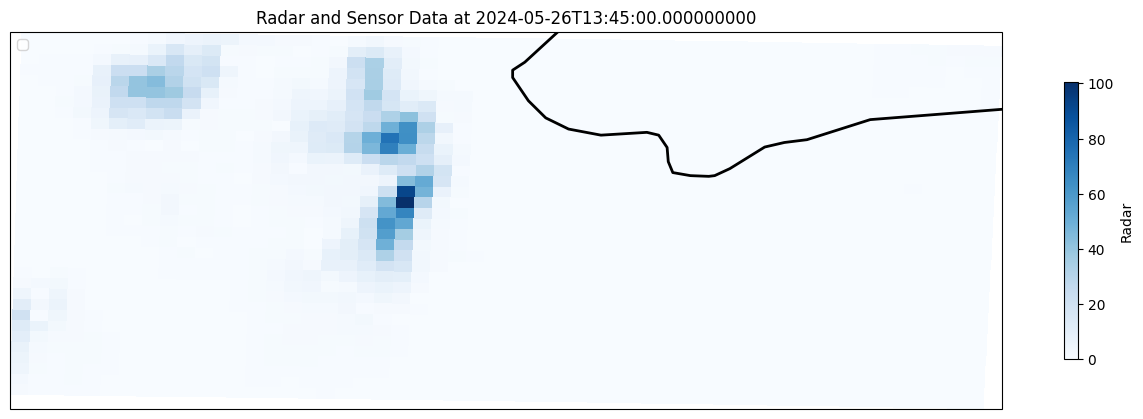

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
# Select a specific time slice for plotting
time_index = 24  # Change to any desired time index
radar_data_at_time = ds['radar_loc'].isel(time=time_index)
# sensor_data_at_time = ds['sensor'].isel(time=time_index)
# Create the plot
plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
# Plot the radar data with a colormap, using UTM transform
radar_plot = plt.pcolormesh(
    ds['lon'], ds['lat'], radar_data_at_time, 
    transform=ccrs.UTM(32), cmap='Blues', shading='auto'
)
plt.colorbar(radar_plot, label='Radar', shrink=0.3)
# Plot the sensor data as points
# Filter out NaN values from the sensor data to get the positions with values
# sensor_x, sensor_y = np.meshgrid(ds['lon'], ds['lat'])
# sensor_values = np.where((sensor_data_at_time >= 0) & ~np.isnan(sensor_data_at_time), sensor_data_at_time, np.nan)
# Only plot non-NaN sensor points

# plt.colorbar(label='Sensor', orientation='horizontal', shrink=0.3, spacing='proportional')
# Add map features
ax.coastlines(linewidth=2)
# ax.gridlines(draw_labels=True)
# Set titles and labels
plt.title(f'Radar and Sensor Data at {str(ds.time[time_index].values)}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper left')
plt.show()

In [ ]:
timerange = pd.date_range(dt(2024,5,26,13), dt(2024,5,26,14), freq="5min")
files_list = [f"hd{timeframe.strftime('%y%m%d%H%M')}.scu" for timeframe in timerange]
print(files_list)

['hd2405261300.scu', 'hd2405261305.scu', 'hd2405261310.scu', 'hd2405261315.scu', 'hd2405261320.scu', 'hd2405261325.scu', 'hd2405261330.scu', 'hd2405261335.scu', 'hd2405261340.scu', 'hd2405261345.scu', 'hd2405261350.scu', 'hd2405261355.scu', 'hd2405261400.scu']


In [ ]:
sensor_id_df

NameError: name 'sensor_id_df' is not defined